# Dependency

Install the following required package

In [138]:
!pip install tensorflow keras pandas xlrd sklearn 

# Load Data 

In [508]:
import pandas as pd 
import numpy as np 

In [509]:
df= pd.read_excel('index_LSTM.xlsx')

In [510]:
df.columns

Index(['date', 'HS300', 'ZZ500', 'BOND', 'CREDIT', 'Commodity', 'PPI %',
       'CPI %', 'M2', 'Lending', 'Industrial', 'PMI', 'Spread', 'VOL300',
       'VOL500', 'BDI', 'USD/CNY', 'USD', 'Unnamed: 18', 'Unnamed: 19',
       'Unnamed: 20'],
      dtype='object')

In [511]:
df.head(3)

,date,HS300,ZZ500,BOND,CREDIT,Commodity,PPI %,CPI %,M2,Lending,...,PMI,Spread,VOL300,VOL500,BDI,USD/CNY,USD,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,2013-04-01,2493.187,3470.960,145.0057,129.3688,1275.27,-1.951818,2.083986,15.718182,25145.090909,...,50.886364,97.25622,47.346022,32.953823,910,6.2674,82.73,NaN,NaN,NaN
1,2013-04-02,2486.391,3428.500,145.1998,129.5004,1285.43,-1.983636,2.098373,15.736364,24787.181818,...,50.872727,96.16199,55.684152,37.863676,896,6.2586,82.89,NaN,NaN,NaN
2,2013-04-03,2483.547,3397.232,145.3059,129.6099,1278.72,-2.015455,2.112759,15.754545,24429.272727,...,50.859091,94.08273,45.564221,36.721020,877,6.2609,82.76,NaN,NaN,NaN


Set your own parameters

In [512]:
start_date ='2013-04-01' # t1 = 2013-04-01
num_input_day = 10   # t1~t10
time_lag = 1
num_output_day = 1  # t10 + time_lag = t11
input_features = ['CPI %','M2', 'Industrial','ZZ500','BOND','CREDIT']
output = ['HS300']

## Min-max scale

Conduct min-max scale in input cols and target cols

In [513]:
def minmax_scale(df,input_cols,output):
    from sklearn.preprocessing import MinMaxScaler
    sc_x = MinMaxScaler(feature_range=(0,1))
    sc_y = MinMaxScaler(feature_range=(0,1))
    df_x_scaled= sc_x.fit_transform(df[input_cols])
    df_y_scaled= sc_y.fit_transform(df[output])
    df[input_cols]=df_x_scaled
    df[output]=df_y_scaled
    return df,sc_y

In [514]:
df_scaled,scaler = minmax_scale(df=df,input_cols=input_features,output=output)
df_scaled.head(3)

,date,HS300,ZZ500,BOND,CREDIT,Commodity,PPI %,CPI %,M2,Lending,...,PMI,Spread,VOL300,VOL500,BDI,USD/CNY,USD,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,2013-04-01,0.124349,0.030243,0.133864,0.013870,1275.27,-1.951818,0.350816,0.955941,25145.090909,...,50.886364,97.25622,47.346022,32.953823,910,6.2674,82.73,NaN,NaN,NaN
1,2013-04-02,0.122268,0.025144,0.137721,0.016332,1285.43,-1.983636,0.354734,0.958193,24787.181818,...,50.872727,96.16199,55.684152,37.863676,896,6.2586,82.89,NaN,NaN,NaN
2,2013-04-03,0.121398,0.021389,0.139830,0.018381,1278.72,-2.015455,0.358651,0.960445,24429.272727,...,50.859091,94.08273,45.564221,36.721020,877,6.2609,82.76,NaN,NaN,NaN


# Create LSTM input-label data

In [515]:
def generate_lstm_input_label(df,start_date,num_input_day,num_output_day,time_lag,input_features,output):
    '''
    Input : [date,num_features]
    
    Output:
        x_temp : [batch_size,time_steps,num_features]
        y_temp : [batch_size,time_steps,num_output]
    '''
    start_date_tstamp = pd.to_datetime(start_date, format='%Y-%m-%d', errors='ignore')
    start_index= list(df_drop['date']).index(start_date_tstamp)
    
    # Create zero-like matrix to store rolling-window time data
    x_temp = np.zeros((len(df_drop)-start_index-num_input_day-num_output_day-time_lag, num_input_day, len(input_features)))
    y_temp = np.zeros((len(df_drop)-start_index-num_input_day-num_output_day-time_lag, num_output_day, len(output)))
    
    matrix_index = 0 
    for i in range(start_index,len(df_drop)-num_input_day-num_output_day-time_lag):
        x_temp[matrix_index,:,:] = df_drop[input_features].values[i:i+num_input_day,:]
        matrix_index +=1
        
    matrix_index = 0 
    for i in range(start_index,len(df_drop)-num_input_day-num_output_day-time_lag):
        y_temp[matrix_index,:,:] = df_drop[output].values[i+num_input_day+time_lag:i+num_input_day+num_output_day+time_lag,:]
        matrix_index +=1
    return x_temp, y_temp

In [516]:
X_set, Y_set= generate_lstm_input_label(df=df_scaled,\
                                        start_date=start_date,\
                                        time_lag=time_lag,\
                                        num_input_day=num_input_day,\
                                        num_output_day=num_output_day,\
                                        input_features=input_features,\
                                        output=output)

# Modeling

### Train,valid,test split

In [517]:
print('Total number of data sample is {}'.format(len(X_set)))

Total number of data sample is 1612


In [518]:
def generate_split_data(X,Y,prec):
    train_index = range(int(prec[0]*len(X)))
    valid_index = range(int(prec[0]*len(X)),int((prec[0]+prec[1])*len(X)))
    test_index = range(int((prec[0]+prec[1])*len(X)),len(X))
    
    X_train = X[train_index,:,:]
    Y_train = Y[train_index,:,:]
    X_valid = X[valid_index,:,:]
    Y_valid = Y[valid_index,:,:]
    X_test = X[test_index,:,:]
    Y_test = Y[test_index,:,:]
    
    return X_train,Y_train,X_valid,Y_valid,X_test,Y_test

In [519]:
split_prec = [0.8,0.1,0.1]  # train 0.8, valid 0.1 ,test 0.1

X_train,Y_train,X_valid,Y_valid,X_test,Y_test = generate_split_data(X_set,Y_set,split_prec)

In [520]:
# transfer y_matrix from [batch_size,time_steps=1,num_output=1] =>[batch_size, num_output=1]
Y_train = np.squeeze(Y_train,axis=(2)) 
Y_valid = np.squeeze(Y_valid,axis=(2))
Y_test = np.squeeze(Y_test,axis=(2))

### LSTM Modeling

In [521]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks.callbacks import ModelCheckpoint,EarlyStopping

In [522]:
# model parameters
hidden_size = 50

In [523]:
# design network
model = Sequential()
model.add(LSTM(hidden_size, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [524]:
ckp = ModelCheckpoint('lstm_forecast.pt',\
                      monitor='val_loss',\
                      verbose=10,\
                      save_best_only=True)

es = EarlyStopping(monitor='val_loss',\
                   patience=5,\
                   verbose=0)

In [525]:
# fit network
history = model.fit(X_train,\
                    Y_train,\
                    epochs=300,\
                    batch_size=32,\
                    validation_data=(X_valid,Y_valid),\
                    verbose=10,\
                    callbacks=[ckp,es],
                    shuffle=False)

Train on 1289 samples, validate on 161 samples
Epoch 1/300

Epoch 00001: val_loss improved from inf to 0.18572, saving model to lstm_forecast.pt
Epoch 2/300

Epoch 00002: val_loss improved from 0.18572 to 0.09876, saving model to lstm_forecast.pt
Epoch 3/300

Epoch 00003: val_loss improved from 0.09876 to 0.07148, saving model to lstm_forecast.pt
Epoch 4/300

Epoch 00004: val_loss improved from 0.07148 to 0.05448, saving model to lstm_forecast.pt
Epoch 5/300

Epoch 00005: val_loss improved from 0.05448 to 0.04906, saving model to lstm_forecast.pt
Epoch 6/300

Epoch 00006: val_loss improved from 0.04906 to 0.04525, saving model to lstm_forecast.pt
Epoch 7/300

Epoch 00007: val_loss improved from 0.04525 to 0.04071, saving model to lstm_forecast.pt
Epoch 8/300

Epoch 00008: val_loss did not improve from 0.04071
Epoch 9/300

Epoch 00009: val_loss improved from 0.04071 to 0.03691, saving model to lstm_forecast.pt
Epoch 10/300

Epoch 00010: val_loss improved from 0.03691 to 0.03680, saving 

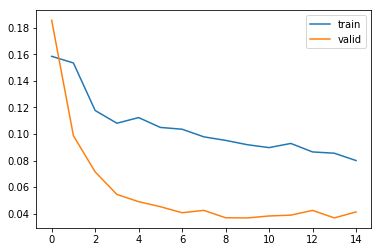

In [526]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

# Evaluate Model

In [527]:
model.load_weights('lstm_forecast.pt')

In [528]:
y_hat = model.predict(X_test)

Inverse_tranform the prediction to original price index (HS300)

In [529]:
y_hat_price = scaler.inverse_transform(y_hat)
y_true_price = scaler.inverse_transform(Y_test)

In [530]:
eval_pred =pd.DataFrame({'time':df['date'][-len(y_hat):],'HS300_Pred':y_hat_price.squeeze(),'HSS300_True':y_true_price.squeeze()})

In [533]:
eval_pred.head(10)

,time,HS300_Pred,HSS300_True
1462,2019-04-03,3533.275146,3971.2852
1463,2019-04-04,3541.276855,4022.1566
1464,2019-04-08,3550.364502,4062.2309
1465,2019-04-09,3560.731201,4057.2286
1466,2019-04-10,3571.320557,4075.4301
1467,2019-04-11,3579.947754,4085.8470
1468,2019-04-12,3588.108154,3997.5778
1469,2019-04-15,3596.730469,3988.6168
1470,2019-04-16,3598.146484,3975.5244
1471,2019-04-17,3598.418457,4085.7891


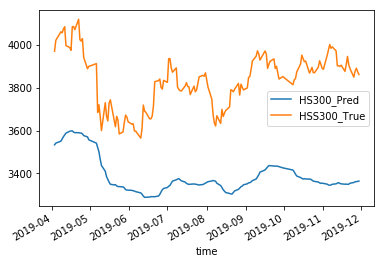

In [531]:
eval_pred.set_index(eval_pred['time']).drop(['time'],axis=1).plot()